<h5><font color='039affff'><b>Part 1</b></font></h5>
This is the first part of the project. Here, we will collect the data and enrich it additional information. We will do the necessary data cleaning and type conversion to allow for a easier time analysing later on. We will also conduct our geospatial analysis here.

Importing libraries

In [78]:
import numpy as np
import pandas as pd
import requests
from geopy.distance import geodesic
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from esda.moran import Moran
from libpysal.weights import KNN
from esda.getisord import G_Local
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from esda.moran import Moran_Local

Load the dataset. This CSV file was taken from https://data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view

In [79]:
df = pd.read_csv('ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')

<h5><font color='039affff'><b>Data quality analysis</b></font></h5>

Firstly, lets check the length of the dataset

In [80]:
print(len(df))

223889


This involves checking for missing values.

In [81]:
print(df.isnull().sum())

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64


Lets see how the data looks like

In [82]:
print(df.head())

     month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  
0      232000.0  
1      250000.0  
2      262000.0  
3      265000.

<h5><font color='039affff'><b>Feature engineering</b></font></h5>

Firstly, we identify columns available in the dataset. 

In [83]:
print(df.columns)

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')


We can see that the dataset does not provide us with much information about the location. 
Lets start by enriching the dataset with information from www.onemap.gov.sg using API calls. 

The first information we can obtain is the number of schools in the area. Schools are a type of amenity that is relatively constant (not much changes to locations or number of schools). Parents may choose to buy houses near schools for accessibility reasons.

In [ ]:
dataset_id = "d_688b934f82c1059ed0a6993d2a829089"
base_url = "https://data.gov.sg"

# Start with initial URL
next_url = f"/api/action/datastore_search?resource_id={dataset_id}"
schools = []

print("Fetching data from API...")

while next_url:
    response = requests.get(base_url + next_url)
    data = response.json()
    
    # Extract records 
    records = data['result']['records']
    schools.extend(records)
    
    links = data.get('result', {}).get('_links', {}) #Get next url
    next_url = links.get('next')
    if len(records) < 100: #Last one
        break

schools_df = pd.DataFrame(schools)
print(f"Total number of schools found: {len(schools_df)}")

Fetching data from API...
Total number of schools found: 337


In [86]:
print(schools_df.columns)

Index(['_id', 'school_name', 'url_address', 'address', 'postal_code',
       'telephone_no', 'telephone_no_2', 'fax_no', 'fax_no_2', 'email_address',
       'mrt_desc', 'bus_desc', 'principal_name', 'first_vp_name',
       'second_vp_name', 'third_vp_name', 'fourth_vp_name', 'fifth_vp_name',
       'sixth_vp_name', 'dgp_code', 'zone_code', 'type_code', 'nature_code',
       'session_code', 'mainlevel_code', 'sap_ind', 'autonomous_ind',
       'gifted_ind', 'ip_ind', 'mothertongue1_code', 'mothertongue2_code',
       'mothertongue3_code'],
      dtype='object')


We can see that there are multiple columns that are not necessary for us. We can drop them first before using the remainder to enrich our dataset

In [87]:
essential_cols = ['school_name', 'address'] 
schools_df = schools_df[essential_cols]

print(schools_df.head())

                      school_name                   address
0        ADMIRALTY PRIMARY SCHOOL    11 WOODLANDS CIRCLE   
1      ADMIRALTY SECONDARY SCHOOL  31 WOODLANDS CRESCENT   
2    AHMAD IBRAHIM PRIMARY SCHOOL    10 YISHUN STREET 11   
3  AHMAD IBRAHIM SECONDARY SCHOOL    751 YISHUN AVENUE 7   
4                  AI TONG SCHOOL  100 Bright Hill Drive   


Now, lets enrich the dataset by determining the distance from the CBD and the number of primary schools within a 2km radius of the HDB.

In [ ]:
# Get coordinates for any address
def get_coordinates(headers, address):
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={address}&returnGeom=Y&getAddrDetails=Y&pageNum=1" 
    response = requests.get(url, headers=headers)
    result = response.json()
    
    if result['found'] > 0:
        latitude = result['results'][0]['LATITUDE']
        longitude = result['results'][0]['LONGITUDE']
    else:
        latitude = None
        longitude = None
    
    return latitude, longitude

raffles_place_latitude, raffles_place_longitude = get_coordinates("Raffles Place MRT Station")

school_coordinates = {}
for schools in schools_df['address'].unique():
    latitude, longitude = get_coordinates(f"{schools}")
    school_name = schools_df[schools_df['address'] == schools]['school_name'].values[0]
    school_coordinates[school_name] = (latitude, longitude)
print("Coordinates of schools obtained.")

street_results = {}
for street in df['street_name'].unique():        
    latitude, longitude = get_coordinates(f"{street}")
    cbd_distance = geodesic((latitude, longitude), (raffles_place_latitude, raffles_place_longitude)).km

    df.loc[df['street_name'] == street, 'Distance to reach CBD (km)'] = cbd_distance

    school_count = 0
    for school_name, (school_lat, school_lon) in school_coordinates.items():
        dist = geodesic((latitude, longitude), (school_lat, school_lon)).km
        if dist < 2:
            school_count += 1

    street_results[street] = {
            'latitude': latitude,
            'longitude': longitude,
            'cbd_distance': cbd_distance,
            'school_count': school_count
        }

df['latitude'] = df['street_name'].map(
    lambda x: street_results[x]['latitude'] if x in street_results else None
)
df['longitude'] = df['street_name'].map(
    lambda x: street_results[x]['longitude'] if x in street_results else None
)
df['Distance to reach CBD (km)'] = df['street_name'].map(
        lambda x: street_results[x]['cbd_distance'] if x in street_results else None
    )
print("Distance to CBD calculated.")

df['Number of schools within 2km'] = df['street_name'].map(
    lambda x: street_results[x]['school_count'] if x in street_results else None
).astype(int)

print("Number of schools within 2km calculated.")

Coordinates of schools obtained.
Distance to CBD calculated.
Number of schools within 2km calculated.


<h5><font color='039affff'><b>Data preprocessing</b></font></h5>
Lets first check that no missing values were created when we enriched the dataset

In [89]:
print(df.isnull().sum())

month                           0
town                            0
flat_type                       0
block                           0
street_name                     0
storey_range                    0
floor_area_sqm                  0
flat_model                      0
lease_commence_date             0
remaining_lease                 0
resale_price                    0
Distance to reach CBD (km)      0
latitude                        0
longitude                       0
Number of schools within 2km    0
dtype: int64


Next, we perform encoding by converting non numerical values into numbers that machine learning models can understand. The first step is to check for columns that need to be changed (not integer or float)

In [90]:
print(df.dtypes)

month                            object
town                             object
flat_type                        object
block                            object
street_name                      object
storey_range                     object
floor_area_sqm                  float64
flat_model                       object
lease_commence_date               int64
remaining_lease                  object
resale_price                    float64
Distance to reach CBD (km)      float64
latitude                         object
longitude                        object
Number of schools within 2km      int64
dtype: object


Floor area (in sqm) and resale prices are known numerical values and can be converted straight to integers. Remaining lease is currently in x years y months format. We can convert it into number of years (decimal) instead

In [91]:
for col in ['floor_area_sqm', 'resale_price']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Extract years and months then convert
df['lease_years'] = df['remaining_lease'].str.extract(r'(\d+) years').astype(float)
df['lease_months'] = df['remaining_lease'].str.extract(r'(\d+) month').astype(float).fillna(0)
df['remaining_lease'] = df['lease_years'] + df['lease_months'] / 12

# Drop redundant columns
df = df.drop(['lease_years', 'lease_months'], axis=1)

The date the flat was sold also plays a key factor in the price. We can convert them into integer since models cant understand datetime. Column 'month' is also renamed to date_sold to better reflect the column value

In [92]:
df['date_sold'] = df['month'].str.replace('-', '')
df['date_sold'] = df['date_sold'].astype(int)
df.drop('month', axis=1, inplace=True)

Let's save this improved dataset for the later stages of the project

In [93]:
df.to_csv('HDB_resale_prices_enhanced.csv', index=False)

The remaining columns will be encoded later


<h5><font color='039affff'><b>EDA</b></font></h5>
We can do some basic EDA to understand the available data

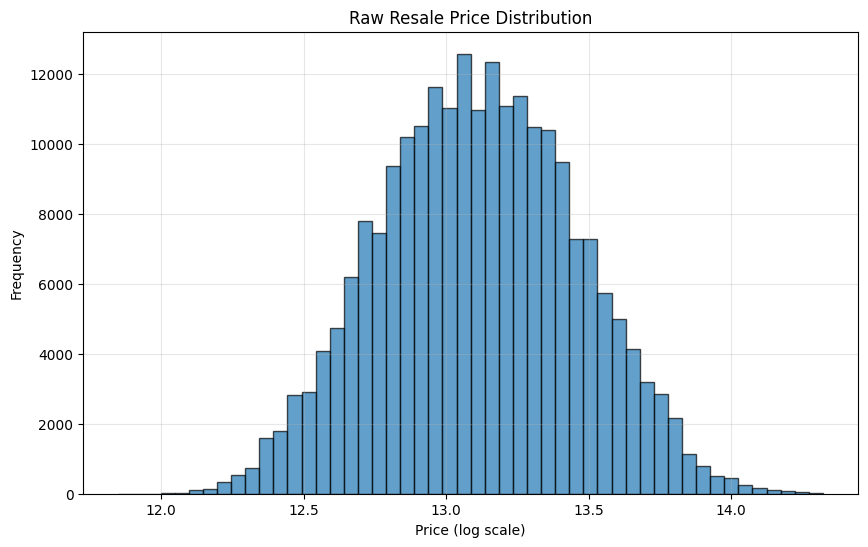


Resale Price Stats:
Mean: $525,528
Median: $495,000
Std Dev: $187,107
Min: $140,000
Max: $1,658,888

=== CATEGORICAL VARIABLES ===

town:
  Unique values: 26
  Top 5: {'SENGKANG': 18296, 'PUNGGOL': 16292, 'WOODLANDS': 15890, 'TAMPINES': 15287, 'YISHUN': 15248}

flat_type:
  Unique values: 7
  Top 5: {'4 ROOM': 94942, '5 ROOM': 54888, '3 ROOM': 53293, 'EXECUTIVE': 16044, '2 ROOM': 4557}

flat_model:
  Unique values: 21
  Top 5: {'Model A': 80118, 'Improved': 54687, 'New Generation': 27372, 'Premium Apartment': 24699, 'Simplified': 8583}

storey_range:
  Unique values: 17
  Top 5: {'04 TO 06': 51350, '07 TO 09': 46949, '10 TO 12': 41830, '01 TO 03': 39451, '13 TO 15': 21560}


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(df['resale_price']), bins=50, edgecolor='black', alpha=0.7)
plt.title('Raw Resale Price Distribution')
plt.xlabel('Price (log scale)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nResale Price Stats:")
print(f"Mean: ${df['resale_price'].mean():,.0f}")
print(f"Median: ${df['resale_price'].median():,.0f}")
print(f"Std Dev: ${df['resale_price'].std():,.0f}")
print(f"Min: ${df['resale_price'].min():,.0f}")
print(f"Max: ${df['resale_price'].max():,.0f}")

print("\n=== CATEGORICAL VARIABLES ===")
categorical_cols = ['town', 'flat_type', 'flat_model', 'storey_range']
for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Top 5: {df[col].value_counts().head(5).to_dict()}")

<h5><font color='039affff'><b>Geospatial Analysis</b></font></h5>
Since locations are considered key features for housing, we can conduct geospatial analysis to analyse deeper. First, let's see where each sale occured on the map.

<Axes: >

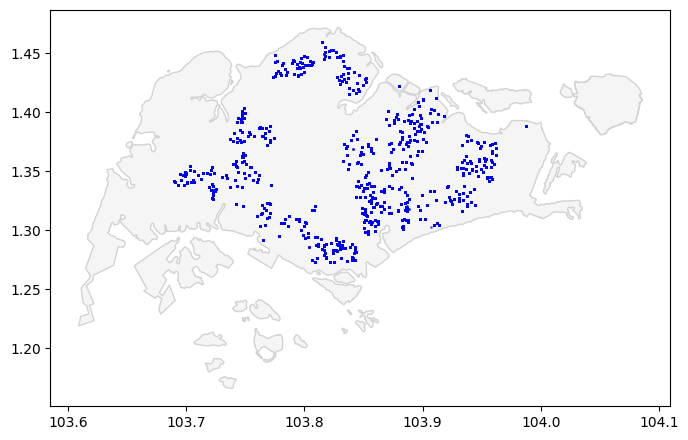

In [95]:
gadm_url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_SGP_shp.zip"
singapore = gpd.read_file(gadm_url, layer='gadm41_SGP_0')

geo_df = df.copy()
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(geo_df, geometry=geometry, crs='EPSG:4326')

ax = singapore.plot(figsize=(8,8), color='whitesmoke', linestyle='-', edgecolor='lightgray')
geo_df.plot(ax=ax, markersize=1, color='blue', alpha=0.5)

We can get the planning areas as a way to section parts of Singapore

In [97]:
dataset_id = "d_4765db0e87b9c86336792efe8a1f7a66"
url = "https://api-open.data.gov.sg/v1/public/api/datasets/" + dataset_id + "/poll-download"
        
response = requests.get(url)
json_data = response.json()
if json_data['code'] != 0:
    print(json_data['errorMsg'])
    exit(1)

url = json_data['data']['url']
response = requests.get(url)

geojson_data = response.json()  

planning_areas = gpd.GeoDataFrame.from_features(geojson_data['features'])
planning_areas.crs = 'EPSG:4326'

We can also see where schools are located to find potential clusters, particularly in relation to planning areas in Singapore

<Axes: >

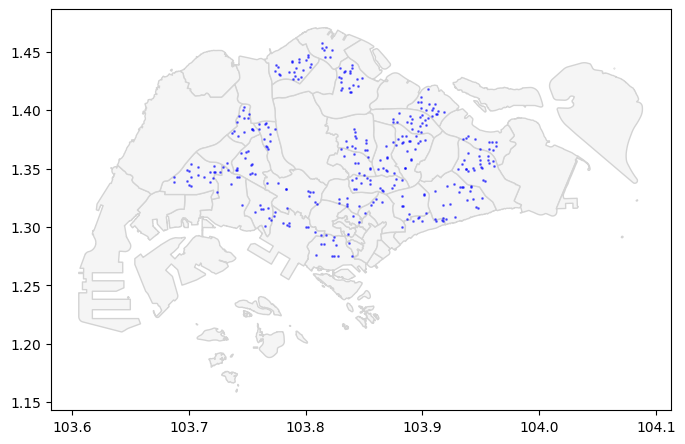

In [98]:
schools_df = pd.DataFrame.from_dict(school_coordinates, orient='index', columns=['latitude', 'longitude'])
schools_df.reset_index(inplace=True)
schools_df.rename(columns={'index': 'school_name'}, inplace=True)
schools_df = schools_df.dropna(subset=['latitude', 'longitude'])

geometry = [Point(xy) for xy in zip(schools_df['longitude'], schools_df['latitude'])]
schools_gdf = gpd.GeoDataFrame(schools_df, geometry=geometry, crs='EPSG:4326')

ax = planning_areas.plot(figsize=(8,8), color='whitesmoke', linestyle='-', edgecolor='lightgray')
schools_gdf.plot(ax=ax, markersize=1, color='blue', alpha=0.5)

We can plot a density graph to make it easier to visualise

In [ ]:
school_counts = gpd.sjoin(schools_gdf, planning_areas[['PLN_AREA_N', 'geometry']], 
                          how='left', predicate='within') \
                   .groupby('PLN_AREA_N').size() \
                   .rename('school_count')
planning_areas['school_count'] = planning_areas['PLN_AREA_N'].map(school_counts).fillna(0)
planning_areas['density'] = planning_areas['school_count'] / (planning_areas['geometry'].to_crs(epsg=3414).area / 1e6)  # Convert to sq km 

#base map
m1 = folium.Map(location=[1.3521, 103.8198], tiles='cartodbpositron', zoom_start=11)
planning_areas = planning_areas.reset_index(drop=True)

Choropleth(geo_data=planning_areas.__geo_interface__,
           data=planning_areas['density'],
           key_on="feature.id",
           fill_color='YlGnBu',
           legend_name='Schools per sq km'
          ).add_to(m1)

m1.save('school_density_map.html') #File is too large to be displayed, refer to saved HTML file

Comparing the school density map (school_density_map.html in the maps folder) to the flats that were sold, we cannot clearly see any correlation. Let's move on to another technique

Technique: Moran's I <ul>
<li>Statistic that measures spatial autocorrelation</li>
<li>Quantifies whether similar values are clustered, dispersed, or randomly distributed across space</li>
<li>Metrics:</li><ul>
    <li>I > 0: positive correlation (similiar prices are clustered together)</li>
    <li>I = 0: no correlation</li>
    <li>I < 0: negative correlation</li>
    <li>The p value is also important. If p < 0.05 --> unlikely to be random and statistically significant</li></ul></ul>
In this case, the value we used will be the price.

In [ ]:
coords = list(zip(df['latitude'], df['longitude']))  
knn = KNN(coords, k=10)  # Each flat connected to 10 nearest neighbors
moran = Moran(df['resale_price'], knn)
print(f"Moran's I (KNN k=10): {moran.I:.3f}")
print(f"p-value: {moran.p_sim:.4f}")

C:\Users\Jun Heng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 566 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Moran's I (KNN k=10): 0.368
p-value: 0.0010


With this score, we can see that similar priced flats are clustered together. It showcases spatial dependence, likely due to shared amenities or the reputation of the town it is situated in. This suggests that if a flat is sold for a certain price, nearby flats will likely sell for a similar price.

Since we have identified that clusters exist, we can start to find hotspots. For that, we can use <b>Getis–Ord Gi*</b>, a local spatial autocorrelation statistic. 
<ul><li>Identifies if values nearby are higher or lower than average</li>
<li>The z score obtained shows how extreme a clustering is around a point. </li><ul>
    <li>Formula: (Gi* - mean(Gi*)) / std(Gi*). 1.96 is the value for 95% confidence.</li>
    <li>Z > +1.96 → Likely a hotspot (high values clustered)</li>
    <li>Z < -1.96 → Likely a coldspot (low values clustered)</li>
    <li>Between -1.96 and +1.96 → Not significantly clustered</li></ul>

<li>Normal for towns to have both hotspots and coldspots</li>
<li>The p value is also used in the same way as above</li>

Hotspots: 38936
Coldspots: 50773


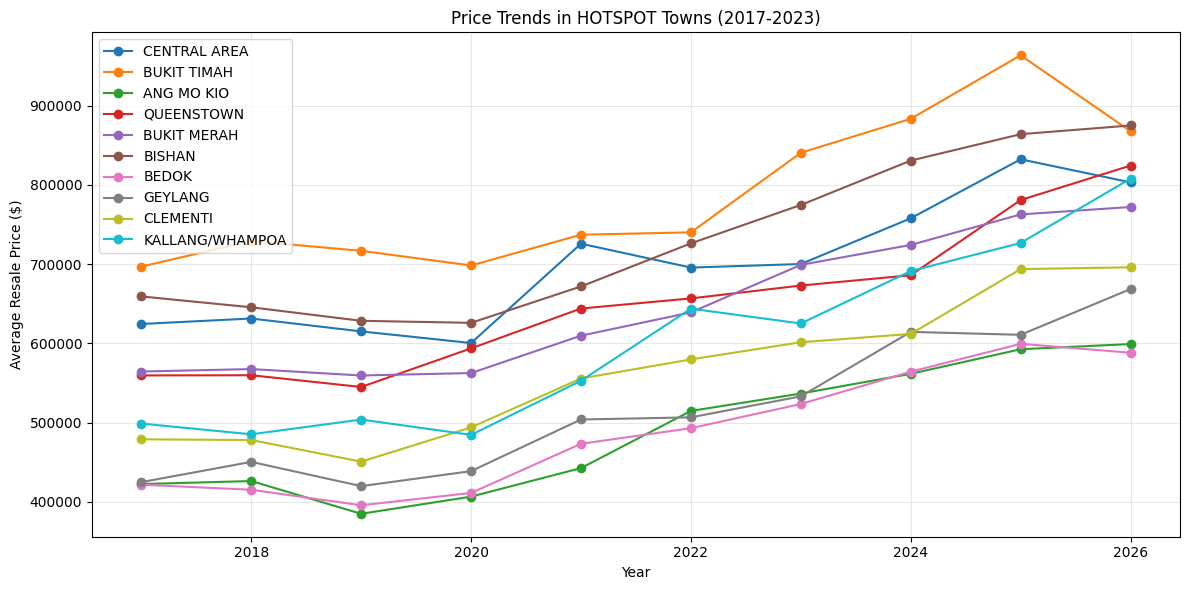

In [ ]:
# Identify price hotspots/coldspots
gi = G_Local(df['resale_price'], knn)

# Classify clusters
df['is_hotspot'] = (gi.p_sim < 0.05) & (gi.Zs > 0)
df['is_coldspot'] = (gi.p_sim < 0.05) & (gi.Zs < 0)

print(f"Hotspots: {df['is_hotspot'].sum()}")
print(f"Coldspots: {df['is_coldspot'].sum()}")

# Prepare date for plotting
df['year'] = pd.to_datetime(df['date_sold'].astype(str).str[:6], format='%Y%m').dt.year

def plot_town_trends(filtered_df, title_suffix):
    top_towns = (filtered_df.groupby('town')['resale_price']
                 .mean()
                 .sort_values(ascending=False)
                 .head(10).index)
    
    plt.figure(figsize=(12, 6))
    for town in top_towns:
        town_data = df[df['town'] == town]
        yearly_avg = town_data.groupby('year')['resale_price'].mean()
        plt.plot(yearly_avg.index, yearly_avg.values, label=town, marker='o')
    
    plt.xlabel('Year')
    plt.ylabel('Average Resale Price ($)')
    plt.title(f'Price Trends in {title_suffix} Towns (2017-2023)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_town_trends(df[df['is_hotspot']], 'HOTSPOT')

df.drop(columns=['is_hotspot', 'year'], inplace=True)

To make further sense of the data, we can plot it as a heat map

In [ ]:
# Create a base map
m2 = folium.Map(location=[1.3521, 103.8198], tiles='cartodbpositron', zoom_start=11)

#Add a heatmap to the map
HeatMap(data=geo_df[['latitude', 'longitude']], radius=15).add_to(m2)
m2.save('hotspots.html') #File is too large to be displayed, refer to saved HTML file

Refer to 'hotspots.html' in the maps folder to view the map

A key component of geospatial intelligence is analysing the town's location. 
<ol><li>ANOVA test</li><ul>
    <li>The ANOVA test can help us do that by checking variance between each group and between groups.</li>
    <li>F ratio: Between group variance / Within group variance (High F value shows that categories matters)</li>
    <li>If p < 0.05, groups are significantly different (Not luck)</li></ul>
<li>Tukey's HSD</li>
<ul>
    <li>Used along with the ANOVA test to calculate Honestly Significant Difference (HSD)</li>
    <li>HSD is the minimum difference needed to be statistically significant for groups</li>
    <li>Used by comparing HSD to the difference of various groups</li>
</ul></ol>

In [ ]:
# 1. ANOVA test
town_groups = [df[df['town'] == town]['resale_price'].values for town in df['town'].unique()]
f_stat, p_value = stats.f_oneway(*town_groups)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")
print(f"Towns have {'significantly' if p_value < 0.05 else 'not significantly'} different prices")

# 2. Tukey's HSD for multiple comparisons
tukey = pairwise_tukeyhsd(df['resale_price'], df['town'])
print("\nFirst 5 town comparisons (Tukey HSD):")
summary_data = tukey.summary().data
for row in summary_data[:6]:  
    cleaned_row = [item.item() if hasattr(item, 'item') else item for item in row]
    print(cleaned_row)

ANOVA F-statistic: 972.41, p-value: 0.0000
Towns have significantly different prices

First 5 town comparisons (Tukey HSD):
['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject']
['ANG MO KIO', 'BEDOK', 1648.3324, 1.0, -7491.7544, 10788.4192, False]
['ANG MO KIO', 'BISHAN', 231123.4849, 0.0, 218633.0321, 243613.9378, True]
['ANG MO KIO', 'BUKIT BATOK', 22895.6807, 0.0, 13264.943, 32526.4184, True]
['ANG MO KIO', 'BUKIT MERAH', 158501.4938, 0.0, 148656.0572, 168346.9304, True]
['ANG MO KIO', 'BUKIT PANJANG', 22652.4761, 0.0, 12643.6005, 32661.3517, True]


According to ANOVA F-statistic, the town where flats are sold affects the price. More technically, the null hypothesis that towns have the same mean price is rejected. Combined with Moran's I, it strongly suggests the clustering of prices by location. The findings of Tukey's HSD also support that there is a clear price difference between the towns

The next technique we employ is Local Moran's I (LISA - Local Indicators of Spatial Association). 
<ul><li>Used to identify clusters and outliers using correlation with its neighbours.</li>
<li>Cluster types:</li><ol>
    <li>High-High clusters (hotspots)</li>
    <li>Low-Low clusters (coldspots)</li>
    <li>High-Low outliers (high value surrounded by lows)</li>
    <li>Low-High outliers (low value surrounded by highs)</li>

In [ ]:
lisa = Moran_Local(df['resale_price'], knn)

# Classify spatial patterns
df['lisa_cluster'] = 'Not Significant'
df.loc[lisa.p_sim < 0.05, 'lisa_cluster'] = 'Significant'
df.loc[(lisa.q == 1) & (lisa.p_sim < 0.05), 'lisa_cluster'] = 'High-High (Expensive flat in expensive area)'
df.loc[(lisa.q == 2) & (lisa.p_sim < 0.05), 'lisa_cluster'] = 'Low-Low (Cheap flat in cheap area)'
df.loc[(lisa.q == 3) & (lisa.p_sim < 0.05), 'lisa_cluster'] = 'Low-High (Cheap flat in expensive area)'
df.loc[(lisa.q == 4) & (lisa.p_sim < 0.05), 'lisa_cluster'] = 'High-Low (Expensive flat in cheap area)'

print("Spatial Clusters Found:")
print(df['lisa_cluster'].value_counts())

print("\nCLUSTER PRICE ANALYSIS:")
print("=" * 60)
cluster_stats = df.groupby('lisa_cluster').agg({
    'resale_price': ['mean', 'std', 'count'],
    'floor_area_sqm': 'mean',
    'remaining_lease': 'mean',
    'Distance to reach CBD (km)': 'mean'
}).round(2)

print(cluster_stats)

df.drop(columns=['lisa_cluster'], inplace=True)

Spatial Clusters Found:
lisa_cluster
Not Significant                                 129087
Low-High (Cheap flat in expensive area)          44561
High-High (Expensive flat in expensive area)     29644
High-Low (Expensive flat in cheap area)          11415
Low-Low (Cheap flat in cheap area)                9182
Name: count, dtype: int64

CLUSTER PRICE ANALYSIS:
                                             resale_price                     \
                                                     mean        std   count   
lisa_cluster                                                                   
High-High (Expensive flat in expensive area)    783559.04  174559.32   29644   
High-Low (Expensive flat in cheap area)         663584.37  130133.60   11415   
Low-High (Cheap flat in expensive area)         364444.26   79262.46   44561   
Low-Low (Cheap flat in cheap area)              412612.02   77042.10    9182   
Not Significant                                 517702.23  150776.80  129087 

According to this analysis, we can see that affordable options can be found within expensive neighbourhoods. This suggests that just because a flat is in a "prime" area, the price does not have to be high. Flats that are more expensive while being in "cheaper" neighbourhoods are likely due to the bigger floor area. Expensive flats in "expensive" areas are closer to the CBD, but not by a lot. This is likely because of the size of Singapore, accessibility to places via public transport, and the spread of offices beyond just the CBD.

<h5><font color='039affff'><b>Conclusion for geospatial analysis</b></font></h5>

To summarise, prices between towns differ. With the LISA analysis, we can see that while towns have different mean prices, there are not necessarily due to the distance from the CBD compared to other cities in the world. This pattern is likely due to the planning done by authorities to distrubute office districts across the island and the efficient public transport.

Let's save the data created into a new csv for future usage

In [ ]:
df.to_csv('HDB_resale_prices_enhanced.csv', index=False)